# Sparkify Project Workspace

This workspace is used for the final Capstone project from Udacity. 

### Problem Statement
Given is a timeseries from a fictional music app company with services similar to Spotify or Pandora. Main goal is to identify which users will churn. In giving predictions who is likely to churn the company could take counter measures such as discounts.

Diffrent models are used to predict which user is likely to churn. As this is a unbalanced dataframe of churned and not churned users the f1 metric is used.

Please read the ReadMe and the blog post for further information.

In [1]:
# import libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DateType


from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
import seaborn as sns

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder\
                    .appName('Sparkify')\
                    .getOrCreate()

datafilePath = 'mini_sparkify_event_data.json'
processed_file_path = 'sparkify_processed_mini.json'

spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '43403'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1595774395042'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '7cf82e3a211a')]

# Load and Clean Dataset


In [3]:
user_log = spark.read.json(datafilePath)
user_log.printSchema()
print((user_log.count(), len(user_log.columns)))

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

(286500, 18)


As the whole Dataframe could be loaded into this workspace with no further problmems, the cleaning will be done after taking a closer look with the EDA

# Exploratory Data Analysis

#### 1. A look into the data. Where Data is missing and how to handle that.

### Note: Churn is (in this worksapce) defined as users who visited the page "Cancellation Confirmation"

#### 2. How churn is defined and how many users churn. Behavior for users who stayed vs users who churned.
##### Please note that some of the behavior analytics are directly in the Feature Engineering Section



In [4]:
user_log.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

###  From this point on first and last Name of the user won't be used in the exploration and feature Engineering any longer as it holds no valuable information for the prediction.

Showing the distinct or counted values for columns

In [5]:
# ToDO describing why which column was used, also where is the column length
# analysis of each column

for s in user_log.schema:    
    if str(s.name) in ['auth','gender','level' ,'location',\
                          'method','page','status']:
        print(user_log.select(s.name).distinct().show())
    if str(s.name) in ['userId','artist','itemInSession']:
        print("{} count : ".format(s.name), user_log.select(s.name).distinct().count())

artist count :  17656
+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

None
+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+

None
itemInSession count :  1322
+-----+
|level|
+-----+
| free|
| paid|
+-----+

None
+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows

None
+------+
|method|
+------+
|   PUT|
|   GET|
+------+

None
+--------------------+
|                page|
+--------------------+
|    

There are 226 distinct users in the dataframe. Method refers to the http methods and status for the correspondent http status codes and wont be used any further with the excpetion of the missing values analysis. As this seem to hold no valuable information it won't be use any further also with the excpetion of the missing values analysis. This also applies to the column userAgent.

### Exploring null values in the dataframe

In [6]:
# how many null values there are for each column
user_log.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in user_log.columns]).collect()

[Row(artist=58392, auth=0, firstName=8346, gender=8346, itemInSession=0, lastName=8346, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=0)]

In [7]:
# # exploring null vlaues in column location
user_log.filter(user_log["location"].isNull())\
        .select("page")\
        .distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [8]:
# exploring null vlaues in column firstName
user_log.filter(user_log["firstName"].isNull())\
        .select("page")\
        .distinct()\
        .show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



The columns firstName, gender, lastName, location (where user is based), registration (since when) and userAgent all have 8346 rows with missing columns. Not only is the number suspiciously the sameand appear on the same page visits, but these also are all user based informations. As there only occur on the pages Home, About, Submit Registration, Login, Register, Help, Error we can conclude, that the user is not logged at these page visits, thus data is missing.

As we need to specify each datapoint to one user (to analyse churn behavior) these rows will later be deleted.

In [9]:
# exploring null vlaues in column song
user_log.filter(user_log["song"].isNull())\
        .select("page")\
        .distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
+--------------------+
only showing top 20 rows



In [10]:
# exploring null vlaues in column artist
user_log.filter(user_log["artist"].isNull())\
        .select("page")\
        .distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
+--------------------+
only showing top 20 rows



Here we have the a similar case as with the missing user specific data. Here all song specific data is missing when a user does somehting which is not directly related to the songs. 

As it still holds valuable information in terms of user behavior the data will stay in place to derive features out of it later.

In [11]:
# dropping data with missing userId oder sessionId as previously discussed
user_log_valid = user_log.dropna(how="any", subset=["userId","sessionId"])

user_log_valid.count()

286500

In [12]:
# also dropping users with an empty string as ID

user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")
user_log_valid.count()


278154

In [13]:
# checking how many distinct users are left
user_log_valid.select('userId').distinct().count()

225

In [14]:
user_log_valid = user_log_valid.select(["userId", "gender", "level", "page", "registration", "sessionId", "ts"])

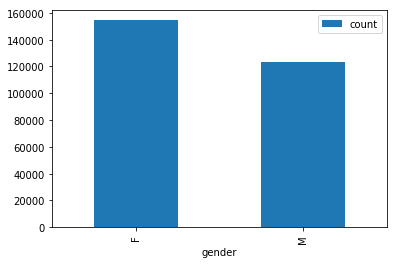

In [15]:
# ration gender in dataset
gender_df = user_log_valid.select(F.col("userId"),F.col("gender"))
gender_df_plot = gender_df.groupby(gender_df.gender).count().toPandas()

gender_df_plot.plot.bar(x='gender', y='count', color='C0')
plt.show()

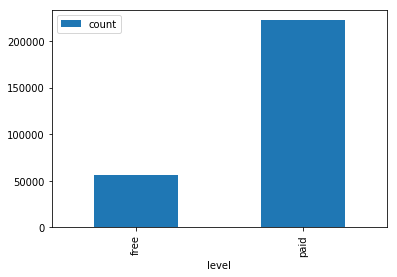

In [16]:
# ration level in dataset
level_df = user_log_valid.select(F.col("userId"),F.col("level"))
level_df_plot = level_df.groupby(level_df.level).count().toPandas()

level_df_plot.plot.bar(x='level', y='count', color='C0')
plt.show()

### Churn is defined as users who visited the page "Cancellation Confirmation"

In [17]:
# find churn example
user_log_valid.filter("page = 'Cancellation Confirmation'").show(3)

+------+------+-----+--------------------+-------------+---------+-------------+
|userId|gender|level|                page| registration|sessionId|           ts|
+------+------+-----+--------------------+-------------+---------+-------------+
|    18|     M| paid|Cancellation Conf...|1535623466000|      514|1538943990000|
|    32|     M| paid|Cancellation Conf...|1537167593000|      540|1539033046000|
|   125|     M| free|Cancellation Conf...|1533157139000|      174|1539318918000|
+------+------+-----+--------------------+-------------+---------+-------------+
only showing top 3 rows



In [18]:
# flag for churn
flag_churn_event = F.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [19]:
# add column with churn (1 churned, 0 stayed)
user_log_valid = user_log_valid.withColumn("churn", flag_churn_event("page"))

# check example
user_log_valid.head()

Row(userId='30', gender='M', level='paid', page='NextSong', registration=1538173362000, sessionId=29, ts=1538352117000, churn=0)

In [20]:
# aggregate churn by event
events_in_churn = user_log_valid.groupby(user_log_valid.churn).count() \
                                 .orderBy(user_log_valid.churn)
events_in_churn.show()

+-----+------+
|churn| count|
+-----+------+
|    0|278102|
|    1|    52|
+-----+------+



We can see that in this dataframe 52 users have churned in total.

Next we group by users to get a more detailed look.

In [21]:

# aggregate churn by userId
users_in_churn = user_log_valid.groupby(user_log_valid.userId,
                                         user_log_valid.gender).agg({"churn": "max"}) 

# rename aggregated columns
users_in_churn = users_in_churn.select(F.col("userId"),
                                       F.col("gender"),
                                       F.col("max(churn)").alias("churn"))


# distribution by churn
dist_churn = users_in_churn.groupby(users_in_churn.churn) \
                           .count() \
                           .orderBy(users_in_churn.churn)
dist_churn_pd = dist_churn.toPandas()
dist_churn_pd

,churn,count
0,0,173
1,1,52


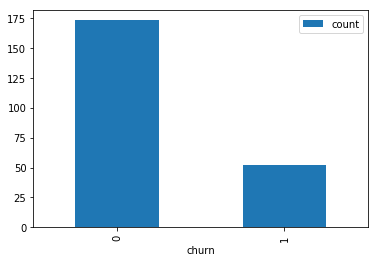

In [22]:
# visualize frequency over time
dist_churn_pd.plot.bar(x='churn', y='count', color='C0')
plt.show()

In [23]:
# percent of churned users
user_log_valid.filter(user_log_valid['churn']==1).select('userId').distinct().count()/user_log_valid.select('userId')\
        .distinct().count() * 100



23.11111111111111

In [24]:

# distribution by churn
dist_churn_gender = users_in_churn.groupby(users_in_churn.churn, users_in_churn.gender) \
                           .count() \
                           .orderBy(users_in_churn.churn)
dist_churn_gender_pd = dist_churn_gender.toPandas()

# visualize churn distribution
dist_churn_gender_pd.head()



,churn,gender,count
0,0,M,89
1,0,F,84
2,1,F,20
3,1,M,32


In total 23% of the usern in the dataset churned. 

It can be seen, that about 20% of the females churned and 26% of the males. According to this data man are more likely to churn.

At this point it can also be concluded that this is a inbalanced dataset as there are far more not churned users than churned ones.

## Here some fancy VIZ

## Feature Engineering

In the this section following 12 features are implented, in two categories. 

User related features:
 - downgraded (if a user downgraded from a paid version)
 - gender_female (indicator for gender)
 - level_paid (if user uses paid version)
 - registered_days (how many days past since user registered)
 - days_since_online (how many days past since he was last online)
 
Song / Session related features
 - playlistSongs (how many songs the user put on a playlist)
 - thumbsUp (how many thumps up)
 - thumbsDown (how many thumps down)
 - add_friend (how many friends user added)
 - sessions (how many sessions a user had)
 - songs (average of how many songs a user played in one session)




In [25]:
# filter to only include columns needed
event = user_log_valid.select(["userId", "gender", "level", "page", "registration", "sessionId", "ts", "churn"])

# display example
event.show(1)


+------+------+-----+--------+-------------+---------+-------------+-----+
|userId|gender|level|    page| registration|sessionId|           ts|churn|
+------+------+-----+--------+-------------+---------+-------------+-----+
|    30|     M| paid|NextSong|1538173362000|       29|1538352117000|    0|
+------+------+-----+--------+-------------+---------+-------------+-----+
only showing top 1 row



In [26]:
# change timestamp into new format
get_time = F.udf(lambda x: pd.Timestamp(x / 1000.0,unit='s').strftime("%Y-%m-%d %H:%M:%S"))
event = event.withColumn("time", get_time(event.ts)).withColumn('registration_time',get_time(event.registration))
event = event.withColumn('month', F.month(F.col('time')))
event = event.withColumn('date', F.from_unixtime(F.col('ts')/1000).cast(DateType()))

user_time=event.groupBy('userId','registration').agg(F.min('time'),F.max('time'))
user_time=user_time.select('userId','registration',
                          F.to_timestamp('min(time)', 'yyyy-MM-dd HH:mm:ss').alias('first_time'),
                          F.to_timestamp('max(time)', 'yyyy-MM-dd HH:mm:ss').alias('last_time'))

# calculate days between last day for a user and last day in df
user_time=user_time.withColumn('registered_days',F.datediff('last_time','first_time')).withColumn(
    'days_since_online',F.datediff(F.to_date(F.lit("2018-12-03")),'last_time')) #(2018-12-03) is the last date in the dataframe
user_time=user_time.select('userId','registered_days','days_since_online')

The user_time dataframe will alter be joined with the feature df. To create the next features only relevant columns are taken from the event df.

In [27]:
# filter to only include columns needed
event = user_log_valid.select(["userId", "gender", "level", "page", "registration", "sessionId", "ts", "churn"])

# display example
event.show(1)

+------+------+-----+--------+-------------+---------+-------------+-----+
|userId|gender|level|    page| registration|sessionId|           ts|churn|
+------+------+-----+--------+-------------+---------+-------------+-----+
|    30|     M| paid|NextSong|1538173362000|       29|1538352117000|    0|
+------+------+-----+--------+-------------+---------+-------------+-----+
only showing top 1 row



In [28]:
# transformation for feature downgraded
flag_downgrade = F.udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
event = event.withColumn("downgraded", flag_downgrade("page"))
event.select(["userId", "ts", "page", "downgraded"])\
     .where(event.userId == "42")\
     .show(5)


+------+-------------+---------+----------+
|userId|           ts|     page|downgraded|
+------+-------------+---------+----------+
|    42|1538418982000|     Home|         0|
|    42|1538599551000|     Home|         0|
|    42|1538599726000| NextSong|         0|
|    42|1538599998000| NextSong|         0|
|    42|1538599999000|Thumbs Up|         0|
+------+-------------+---------+----------+
only showing top 5 rows



In [29]:
# transformation for feature gender
flag_gender = F.udf(lambda x: 1 if x == "F" else 0, IntegerType())
event = event.withColumn("gender_female", flag_gender("gender"))
event.select(["userId", "gender", "gender_female"])\
     .where(event.userId == "42")\
     .show(1)


+------+------+-------------+
|userId|gender|gender_female|
+------+------+-------------+
|    42|     F|            1|
+------+------+-------------+
only showing top 1 row



In [30]:
# transformation for feature level
flag_level = F.udf(lambda x: 1 if x == "paid" else 0, IntegerType())
event = event.withColumn("level_paid", flag_level("level"))
event.select(["userId", "ts", "level", "level_paid"])\
     .where(event.userId == "42")\
     .show(10)

+------+-------------+-----+----------+
|userId|           ts|level|level_paid|
+------+-------------+-----+----------+
|    42|1538418982000| free|         0|
|    42|1538599551000| free|         0|
|    42|1538599726000| free|         0|
|    42|1538599998000| free|         0|
|    42|1538599999000| free|         0|
|    42|1538600156000| free|         0|
|    42|1538600478000| free|         0|
|    42|1538600715000| free|         0|
|    42|1538601191000| free|         0|
|    42|1538601393000| free|         0|
+------+-------------+-----+----------+
only showing top 10 rows



In [31]:
# transformation for feature playlistSongs
flag_playlist_event = F.udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
event = event.withColumn("playlistSongs", flag_playlist_event("page"))
event.select(["userId", "ts", "page", "playlistSongs"])\
     .where(event.userId == "42")\
     .show(10)

+------+-------------+---------+-------------+
|userId|           ts|     page|playlistSongs|
+------+-------------+---------+-------------+
|    42|1538418982000|     Home|            0|
|    42|1538599551000|     Home|            0|
|    42|1538599726000| NextSong|            0|
|    42|1538599998000| NextSong|            0|
|    42|1538599999000|Thumbs Up|            0|
|    42|1538600156000| NextSong|            0|
|    42|1538600478000| NextSong|            0|
|    42|1538600715000| NextSong|            0|
|    42|1538601191000| NextSong|            0|
|    42|1538601393000| NextSong|            0|
+------+-------------+---------+-------------+
only showing top 10 rows



In [32]:
# transformation for feature add_friend
flag_add_friend_event = F.udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
event = event.withColumn("add_friend", flag_add_friend_event("page"))
event.select(["userId", "ts", "page", "add_friend"])\
     .where(event.userId == "42")\
     .show(10)

+------+-------------+---------+----------+
|userId|           ts|     page|add_friend|
+------+-------------+---------+----------+
|    42|1538418982000|     Home|         0|
|    42|1538599551000|     Home|         0|
|    42|1538599726000| NextSong|         0|
|    42|1538599998000| NextSong|         0|
|    42|1538599999000|Thumbs Up|         0|
|    42|1538600156000| NextSong|         0|
|    42|1538600478000| NextSong|         0|
|    42|1538600715000| NextSong|         0|
|    42|1538601191000| NextSong|         0|
|    42|1538601393000| NextSong|         0|
+------+-------------+---------+----------+
only showing top 10 rows



In [33]:
# transformation for feature thumps_up
flag_thumbs_up = F.udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
event = event.withColumn("thumbsUp", flag_thumbs_up("page"))
event.select(["userId", "ts", "page", "thumbsUp"])\
     .where(event.userId == "42")\
     .show(10)

+------+-------------+---------+--------+
|userId|           ts|     page|thumbsUp|
+------+-------------+---------+--------+
|    42|1538418982000|     Home|       0|
|    42|1538599551000|     Home|       0|
|    42|1538599726000| NextSong|       0|
|    42|1538599998000| NextSong|       0|
|    42|1538599999000|Thumbs Up|       1|
|    42|1538600156000| NextSong|       0|
|    42|1538600478000| NextSong|       0|
|    42|1538600715000| NextSong|       0|
|    42|1538601191000| NextSong|       0|
|    42|1538601393000| NextSong|       0|
+------+-------------+---------+--------+
only showing top 10 rows



In [34]:
# transformation for feature thumps_down
flag_thumbs_down = F.udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
event = event.withColumn("thumbsDown", flag_thumbs_down("page"))
event.select(["userId", "ts", "page", "thumbsDown"])\
     .where(event.userId == "42")\
     .show(10)


+------+-------------+---------+----------+
|userId|           ts|     page|thumbsDown|
+------+-------------+---------+----------+
|    42|1538418982000|     Home|         0|
|    42|1538599551000|     Home|         0|
|    42|1538599726000| NextSong|         0|
|    42|1538599998000| NextSong|         0|
|    42|1538599999000|Thumbs Up|         0|
|    42|1538600156000| NextSong|         0|
|    42|1538600478000| NextSong|         0|
|    42|1538600715000| NextSong|         0|
|    42|1538601191000| NextSong|         0|
|    42|1538601393000| NextSong|         0|
+------+-------------+---------+----------+
only showing top 10 rows



In [35]:
# transformation for feature songs
flag_song = F.udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())

event = event.withColumn("song", flag_song("page"))
event.select(["userId", "sessionId", "ts", "page", "song"])\
     .where(event.userId == "42")\
     .show(5)

# Sum up all songs in one session
session = event.groupby(event.userId, event.sessionId)\
               .agg({"song": "sum"}) \
               .select(F.col("userId"), F.col("sessionId"), 
                       F.col("sum(song)").alias("songsInSession"))
session.show(5)

# take average for song in each session for each user
features_session = session.groupby(session.userId)\
                          .agg({"songsInSession": "avg"})\
                          .select(F.col("userId"),
                                  F.round(F.col("avg(songsInSession)"), 1).alias("songs"))

features_session.show(5)


+------+---------+-------------+---------+----+
|userId|sessionId|           ts|     page|song|
+------+---------+-------------+---------+----+
|    42|      291|1538418982000|     Home|   0|
|    42|      304|1538599551000|     Home|   0|
|    42|      304|1538599726000| NextSong|   1|
|    42|      304|1538599998000| NextSong|   1|
|    42|      304|1538599999000|Thumbs Up|   0|
+------+---------+-------------+---------+----+
only showing top 5 rows

+------+---------+--------------+
|userId|sessionId|songsInSession|
+------+---------+--------------+
|    92|      358|            57|
|    42|      433|            16|
|   101|      635|           708|
|   120|      627|           236|
|   140|      798|             3|
+------+---------+--------------+
only showing top 5 rows

+------+-----+
|userId|songs|
+------+-----+
|100010| 39.3|
|200002| 64.5|
|   125|  8.0|
|    51|211.1|
|   124|140.7|
+------+-----+
only showing top 5 rows



In [36]:
event.show()

+------+------+-----+---------------+-------------+---------+-------------+-----+----------+-------------+----------+-------------+----------+--------+----------+----+
|userId|gender|level|           page| registration|sessionId|           ts|churn|downgraded|gender_female|level_paid|playlistSongs|add_friend|thumbsUp|thumbsDown|song|
+------+------+-----+---------------+-------------+---------+-------------+-----+----------+-------------+----------+-------------+----------+--------+----------+----+
|    30|     M| paid|       NextSong|1538173362000|       29|1538352117000|    0|         0|            0|         1|            0|         0|       0|         0|   1|
|     9|     M| free|       NextSong|1538331630000|        8|1538352180000|    0|         0|            0|         0|            0|         0|       0|         0|   1|
|    30|     M| paid|       NextSong|1538173362000|       29|1538352394000|    0|         0|            0|         1|            0|         0|       0|         

In [37]:
# have features on user basis
features_event = event.groupby(event.userId)\
                      .agg({"downgraded": "max", 
                            "gender_female": "max",
                            "level_paid": "max",
                            "playlistSongs": "sum",
                            "thumbsUp": "sum",
                            "thumbsDown": "sum",
                            "add_friend": "sum",
                            "churn": "max",
                            "sessionId" : "count"}) 

features_event.show(5)

+------+-------------+------------------+---------------+------------------+----------------+---------------+----------+---------------+---------------+
|userId|sum(thumbsUp)|sum(playlistSongs)|sum(thumbsDown)|max(gender_female)|count(sessionId)|max(level_paid)|max(churn)|max(downgraded)|sum(add_friend)|
+------+-------------+------------------+---------------+------------------+----------------+---------------+----------+---------------+---------------+
|100010|           17|                 7|              5|                 1|             381|              0|         0|              0|              4|
|200002|           21|                 8|              6|                 0|             474|              1|         0|              0|              4|
|   125|            0|                 0|              0|                 0|              11|              0|         1|              0|              0|
|    51|          100|                52|             21|                 0|      

In [38]:
# rename aggregated columns
features_event = features_event.select(F.col("userId"),
                                       F.col("max(downgraded)").alias("downgraded"),
                                       F.col("max(gender_female)").alias("gender_female"),
                                       F.col("max(level_paid)").alias("level_paid"),
                                       F.col("sum(playlistSongs)").alias("playlistSongs"),
                                       F.col("sum(thumbsUp)").alias("thumbsUp"),
                                       F.col("sum(thumbsDown)").alias("thumbsDown"),
                                       F.col("sum(add_friend)").alias("add_friends"),
                                       F.col("max(churn)").alias("churn"),
                                       F.col("count(sessionId)").alias("sessions"))
# present result
features_event.show(5)

+------+----------+-------------+----------+-------------+--------+----------+-----------+-----+--------+
|userId|downgraded|gender_female|level_paid|playlistSongs|thumbsUp|thumbsDown|add_friends|churn|sessions|
+------+----------+-------------+----------+-------------+--------+----------+-----------+-----+--------+
|100010|         0|            1|         0|            7|      17|         5|          4|    0|     381|
|200002|         0|            0|         1|            8|      21|         6|          4|    0|     474|
|   125|         0|            0|         0|            0|       0|         0|          0|    1|      11|
|    51|         0|            0|         1|           52|     100|        21|         28|    1|    2464|
|   124|         0|            1|         1|          118|     171|        41|         74|    0|    4825|
+------+----------+-------------+----------+-------------+--------+----------+-----------+-----+--------+
only showing top 5 rows



In [39]:
features=features_event.join(features_session, ['userId'])
features.show(n=5)

+------+----------+-------------+----------+-------------+--------+----------+-----------+-----+--------+-----+
|userId|downgraded|gender_female|level_paid|playlistSongs|thumbsUp|thumbsDown|add_friends|churn|sessions|songs|
+------+----------+-------------+----------+-------------+--------+----------+-----------+-----+--------+-----+
|100010|         0|            1|         0|            7|      17|         5|          4|    0|     381| 39.3|
|200002|         0|            0|         1|            8|      21|         6|          4|    0|     474| 64.5|
|   125|         0|            0|         0|            0|       0|         0|          0|    1|      11|  8.0|
|   124|         0|            1|         1|          118|     171|        41|         74|    0|    4825|140.7|
|    51|         0|            0|         1|           52|     100|        21|         28|    1|    2464|211.1|
+------+----------+-------------+----------+-------------+--------+----------+-----------+-----+--------

In [40]:
features=features.join(user_time, ['userId']).drop(features.userId)
features.show(n=5)

+----------+-------------+----------+-------------+--------+----------+-----------+-----+--------+-----+---------------+-----------------+
|downgraded|gender_female|level_paid|playlistSongs|thumbsUp|thumbsDown|add_friends|churn|sessions|songs|registered_days|days_since_online|
+----------+-------------+----------+-------------+--------+----------+-----------+-----+--------+-----+---------------+-----------------+
|         0|            1|         0|            7|      17|         5|          4|    0|     381| 39.3|             44|               12|
|         0|            0|         1|            8|      21|         6|          4|    0|     474| 64.5|             45|               18|
|         0|            0|         0|            0|       0|         0|          0|    1|      11|  8.0|              0|               52|
|         0|            1|         1|          118|     171|        41|         74|    0|    4825|140.7|             60|                3|
|         0|            0| 

In [41]:
# check all features
features.printSchema()

root
 |-- downgraded: integer (nullable = true)
 |-- gender_female: integer (nullable = true)
 |-- level_paid: integer (nullable = true)
 |-- playlistSongs: long (nullable = true)
 |-- thumbsUp: long (nullable = true)
 |-- thumbsDown: long (nullable = true)
 |-- add_friends: long (nullable = true)
 |-- churn: integer (nullable = true)
 |-- sessions: long (nullable = false)
 |-- songs: double (nullable = true)
 |-- registered_days: integer (nullable = true)
 |-- days_since_online: integer (nullable = true)



# Modeling


In the modeling section tree models will be build. 

1. Linear Regression Model
2. Random Forest Model
3. Gradiant Boosting Modle

As previously discussed F1 will be the metric to optimize

In [42]:
# Train and Test Split
train, test = features.randomSplit([0.7, 0.3], seed = 42)

print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 163
Test Dataset Count: 62


In [43]:
def build_model(classifier, param):
    """
    Builds a model based on the inputs
    
    Args
    -------
    classifier: type of classifier
    param: built param grid
    
    Returns
    -------
    model:
      ML pipeline model
      
    """
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

In [44]:
feature_columns = [col for col in features.columns if col!='churn']

## Logistic Regression

In [45]:
#Logistic Regression
lr = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
lr_param = ParamGridBuilder().build()
model = build_model(lr, lr_param)


In [46]:
%%time
fit_model = model.fit(train)

CPU times: user 8.96 s, sys: 4.36 s, total: 13.3 s
Wall time: 15min 31s


In [47]:
pred = fit_model.transform(test)

pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [48]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
print("f1 using Logistic Regression: {}".format(f1_score))


f1 using Logistic Regression: 0.877630115332826


## Random Forest

In [49]:
#RandomForest
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)

In [50]:
%%time
rf_fit_model = rf_model.fit(train)

CPU times: user 2.36 s, sys: 847 ms, total: 3.2 s
Wall time: 7min 7s


In [51]:
rf_pred = rf_fit_model.transform(test)


In [52]:
rf_f1_score = evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"})
print("f1 using Random Forest: {}".format(rf_f1_score))

f1 using Random Forest: 0.9150190773499827


## Gradiant Boosting

In [53]:
#GradiantBoosting
gbt =GBTClassifier(featuresCol="scaled_features", labelCol="churn")
gbt_param = ParamGridBuilder().build()
gbt_model = build_model(gbt, gbt_param)

In [54]:
%%time
gbt_fit_model = gbt_model.fit(train)

CPU times: user 13.2 s, sys: 6.06 s, total: 19.3 s
Wall time: 27min 11s


In [55]:
gbt_pred = gbt_fit_model.transform(test)

In [56]:
gbt_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [57]:
gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
print("f1 using Gradient Boosting: {}".format(gbt_f1_score))

f1 using Gradient Boosting: 0.793405017921147
